# Download and extract video

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pytube

In [0]:
import cv2
from pytube import YouTube
from pathlib import Path

In [0]:
%cd drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/notebook

/content/drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/notebook


https://www.youtube.com/watch?v=MLDwPH5qBtY

In [0]:
save_dir = Path('../data/source/')
save_dir.mkdir(exist_ok=True)

img_dir = save_dir.joinpath('images')
img_dir.mkdir(exist_ok=True)

In [0]:
# Bruno Mars - That's What I Like
yt = YouTube('https://www.youtube.com/watch?v=MLDwPH5qBtY')
yt.streams.first().download(save_dir, 'mv')

NameError: ignored

In [0]:
cap = cv2.VideoCapture(str(save_dir.joinpath('mv (2).mp4')))
i = 0
while(cap.isOpened()):
    flag, frame = cap.read()
    if flag == False or i == 1000:
        break
    cv2.imwrite(str(img_dir.joinpath(f'img_{i:04d}.png')), frame)
    i += 1

content/drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/data/source/mv (1).mp4

# Pose estimation (OpenPose)

In [0]:
!pip3 install torch torchvision

    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61ca2000 @  0x7f05d26232a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 23.1MB/s 
    100% |████████████████████████████████| 2.0MB 4.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

%matplotlib inline

In [0]:
openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')

%reload_ext autoreload
%autoreload 2

In [0]:
!pip install cython pycocotools tensorboardX torch-encoding

    100% |████████████████████████████████| 112kB 2.4MB/s 
    100% |████████████████████████████████| 92kB 26.4MB/s 


In [0]:
# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose

In [0]:
import torch
torch.cuda.is_available()

True

In [0]:
weight_name = openpose_dir.joinpath('pose_model.pth')
model = get_model('vgg19')     
model.load_state_dict(torch.load(weight_name))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()
pass

Bulding VGG19


## check

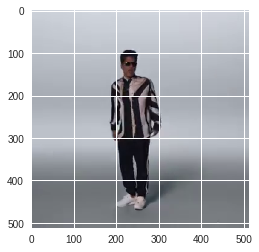

In [0]:
img_path = sorted(img_dir.iterdir())[137]
img = cv2.imread(str(img_path))
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

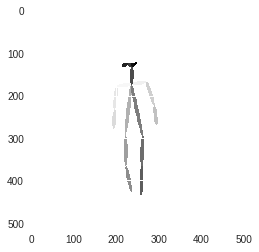

In [0]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label = get_pose(param, heatmap, paf)

plt.imshow(label)

## make label images for pix2pix

In [0]:
test_img_dir = save_dir.joinpath('test_img')
test_img_dir.mkdir(exist_ok=True)
test_label_dir = save_dir.joinpath('test_label')
test_label_dir.mkdir(exist_ok=True)

for idx in tqdm(range(171, 171+50)):
    img_path = img_dir.joinpath(f'img_{idx:04d}.png')
    img = cv2.imread(str(img_path))
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2

    img = img[oh:oh+shape_dst, ow:ow+shape_dst]
    img = cv2.resize(img, (512, 512))
    multiplier = get_multiplier(img)
    with torch.no_grad():
        paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
    heatmap[:, :, :-1] = r_heatmap
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    label = get_pose(param, heatmap, paf)
    cv2.imwrite(str(test_img_dir.joinpath(f'img_{idx:04d}.png')), img)
    cv2.imwrite(str(test_label_dir.joinpath(f'label_{idx:04d}.png')), label)
    
torch.cuda.empty_cache()

100%|██████████| 50/50 [06:01<00:00,  7.23s/it]
